In [2]:
import os
from dotenv import load_dotenv
from typing import TypedDict

from langgraph.graph import StateGraph, START, END

In [3]:
load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

#### Sequential Workflow


###### Example 01


In [4]:
# Define State
class BMIState(TypedDict):
    weight_kg: float
    height_m: float
    bmi: float

In [13]:
def calculate_bmi(state: BMIState) -> BMIState:
    weight = state['weight_kg']
    height = state['height_m']

    bmi = weight / (height ** 2)
    state['bmi'] = round(bmi, 2)

    return state

In [14]:
# STEP 1: Define Graph
graph = StateGraph(BMIState)

# STEP 2: Add nodes to the graph
NODE_CALCULATE_BMI = 'calculate_bmi'
graph.add_node(NODE_CALCULATE_BMI, calculate_bmi)

# STEP 3: Add edges to the graph
graph.add_edge(START, NODE_CALCULATE_BMI)
graph.add_edge(NODE_CALCULATE_BMI, END)


# STEP 4: Compile the graph
workflow = graph.compile()

In [15]:
# STEP 5: Execute the graph

# Define initial state
initial_state = {
    'weight_kg': 82,
    'height_m': 1.75
}

final_state = workflow.invoke(initial_state)
final_state

{'weight_kg': 82, 'height_m': 1.75, 'bmi': 26.78}

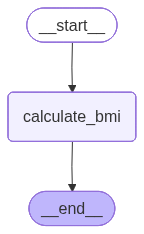

In [16]:
# View the compiled graph
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

###### Example 02


In [17]:
# Define State
class BMIState(TypedDict):
    weight_kg: float
    height_m: float
    bmi: float
    category: str

In [26]:
# Define functions

def calculate_bmi(state: BMIState) -> BMIState:
    weight = state['weight_kg']
    height = state['height_m']

    bmi = weight / (height ** 2)
    state['bmi'] = round(bmi, 2)

    return state


def label_bmi(state: BMIState) -> BMIState:
    bmi = state['bmi']

    if bmi < 18.5:
        state['category'] = 'Underweight'
    elif 18.5 <= bmi < 25:
        state['category'] = 'Normal'
    elif 25 <= bmi < 30:
        state['category'] = 'Overweight'
    else:
        state['category'] = 'Obese'

    return state

In [27]:
# STEP 1: Define Graph
graph = StateGraph(BMIState)

# STEP 2: Add nodes to the graph
NODE_CALCULATE_BMI = 'calculate_bmi'
NODE_LABEL_BMI = 'label_bmi'

graph.add_node(NODE_CALCULATE_BMI, calculate_bmi)
graph.add_node(NODE_LABEL_BMI, label_bmi)

# STEP 3: Add edges to the graph
graph.add_edge(START, NODE_CALCULATE_BMI)
graph.add_edge(NODE_CALCULATE_BMI, NODE_LABEL_BMI)
graph.add_edge(NODE_LABEL_BMI, END)


# STEP 4: Compile the graph
workflow = graph.compile()

In [28]:
# STEP 5: Execute the graph
initial_state = {
    'weight_kg': 82,
    'height_m': 1.75
}

final_state = workflow.invoke(initial_state)
final_state

{'weight_kg': 82, 'height_m': 1.75, 'bmi': 26.78, 'category': 'Overweight'}

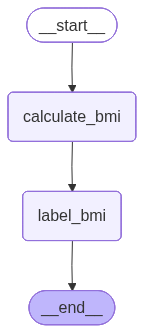

In [29]:
# View the compiled graph
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

###### Example 03 (LLM Workflow)


In [30]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END, START
from typing import TypedDict

In [35]:
model = ChatOpenAI()

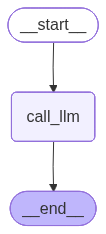

In [36]:
# STEP 1: Define State
class LLMState(TypedDict):
    question: str
    answer: str


# STEP 2: Define Graph
graph = StateGraph(LLMState)

# STEP 3: Add nodes to the graph
NODE_CALL_LLM = 'call_llm'


def llm_qa(state: LLMState) -> LLMState:
    # Extract the question from state
    question = state['question']

    # Form a prompt
    prompt = f'Answer the following question: {question}'

    model = ChatOpenAI()

    # Ask the question to the LLM
    response = model.invoke(prompt)

    # Update the answer in the state
    state['answer'] = response.content

    return state


graph.add_node(NODE_CALL_LLM, llm_qa)


# STEP 4: Add edges to the graph
graph.add_edge(START, NODE_CALL_LLM)
graph.add_edge(NODE_CALL_LLM, END)


# STEP 5: Compile the graph
workflow = graph.compile()
workflow

In [37]:
# STEP 6: Execute the graph
initial_state = {
    'question': 'How far is moon from the earth ?',
}

final_state = workflow.invoke(initial_state)
final_state

{'question': 'How far is moon from the earth ?',
 'answer': 'The average distance from the Earth to the Moon is approximately 384,400 kilometers (238,855 miles).'}

###### Example 04 (Prompt Chaining - Series of LLM Call)


In [44]:
import os
from dotenv import load_dotenv
from typing import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END

load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
model = ChatOpenAI()

In [54]:
# Define the state
class BlogState(TypedDict):
    title: str
    outline: str
    content: str
    rating: str

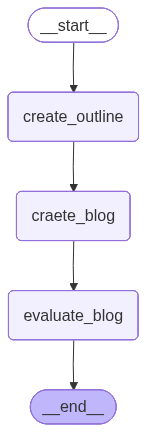

In [52]:
# Define Graph
graph = StateGraph(BlogState)

# Add nodes
NODE_CREATE_OUTLINE = 'create_outline'
NODE_CREATE_BLOG = 'craete_blog'
NODE_EVALUATE_BLOG = 'evaluate_blog'


def create_outline(state: BlogState) -> BlogState:
    title = state['title']

    prompt = f'Generate a detailed outline for a blog on the topic: {title}'
    response = model.invoke(prompt)

    state['outline'] = response.content
    return state


def create_blog(state: BlogState) -> BlogState:
    outline = state['outline']
    title = state['title']

    prompt = f'Write a detailed blog in the title - {title} using the following outline\n{outline}'

    response = model.invoke(prompt)

    state['content'] = response.content
    return state


def evaluate_blog(state: BlogState) -> BlogState:
    outline = state['outline']
    content = state['content']

    prompt = f'Based on the following outline: {outline}\nRate the blog: {content}'

    response = model.invoke(prompt)
    state['rating'] = response.content
    return state


graph.add_node(NODE_CREATE_OUTLINE, create_outline)
graph.add_node(NODE_CREATE_BLOG, create_blog)
graph.add_node(NODE_EVALUATE_BLOG, evaluate_blog)

# Add edges
graph.add_edge(START, NODE_CREATE_OUTLINE)
graph.add_edge(NODE_CREATE_OUTLINE, NODE_CREATE_BLOG)
graph.add_edge(NODE_CREATE_BLOG, NODE_EVALUATE_BLOG)
graph.add_edge(NODE_EVALUATE_BLOG, END)

# Compile the graph
workflow = graph.compile()
workflow

In [53]:
# Execute
initial_state = {
    'title': 'Rise of AI in India'
}

final_state = workflow.invoke(initial_state)

# print(f'TITLE: {final_state['title']}\n')
# print(f'OUTLINE:\n{final_state['outline']}\n\n')
# print(f'Blog:\n{final_state['content']}')
print(f'Rating: {final_state['rating']}')

Rating: Overall, I would rate this blog highly as it covers a comprehensive overview of the rise of AI in India. It addresses key points such as the current state of AI in India, driving factors, challenges, impact on the economy, future projections, and successful case studies. The inclusion of government initiatives, major players, and the skilled workforce in India adds depth to the analysis. The structure of the blog is clear and organized, making it easy for readers to follow along. The call to action at the end encourages engagement and further exploration of AI developments in India. I would rate this blog a 9 out of 10 for its informative content and relevance in today's tech-driven landscape.


#### Parallel Workflow


###### Example 01


###### Example 02


###### Example 03


#### Conditional Workflow


#### Iterative Workflow


#### ChatBot


In [76]:
import os
from pprint import pprint
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

model = ChatOpenAI(model='gpt-4o-mini')

In [59]:
from langgraph.graph.message import add_messages

# State

# AIMessage, SystemMessage, HumanMessgae, all inherit from BaseMessage


class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [66]:
def chat(state: ChatState) -> ChatState:
    # Take user query from state
    messages = state['messages']

    # Send to LLM
    response = model.invoke(messages)

    return {'messages': response}

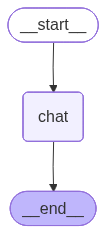

In [68]:
# Create graph, add node, add edge and compile

# Create Graph
graph = StateGraph(ChatState)


# Add Node
NODE_CHAT = 'chat'
graph.add_node(NODE_CHAT, chat)

# Add Edge
graph.add_edge(START, NODE_CHAT)
graph.add_edge(NODE_CHAT, END)

workflow = graph.compile()
workflow

In [73]:
initial_state = {
    'messages': [HumanMessage(content='Hello. How are you ?')]
}

workflow.invoke(initial_state)

{'messages': [HumanMessage(content='Hello. How are you ?', additional_kwargs={}, response_metadata={}, id='c70506a7-5622-4f80-ad92-fc28d9f7eba7'),
  AIMessage(content="Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 13, 'total_tokens': 42, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-Ca2BaPHkjMPHUtyQZI1c0nIFkslee', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--fb51d98f-6373-4821-8933-dc3a5a546cbf-0', usage_metadata={'input_tokens': 13, 'output_tokens': 29, 'total_tokens': 42, 'input_token_

In [81]:
while True:
    user_message = input('What is on your mind: ')
    print(f'User: {user_message}')

    if user_message.strip().lower() in ['exit', 'quit', 'bye']:
        break

    response = workflow.invoke({
        'messages': [HumanMessage(content=user_message)]
    })

    print(f'AI: {response['messages'][-1].content}')

User: I am Pratik
AI: Hello, Pratik! How can I assist you today?
User: How many characters in my name ?
AI: I would need to know your name to count the characters in it. Please provide your name, and I'll help you with the count!
User: My name is pratik
AI: Nice to meet you, Pratik! How can I assist you today?
User: bye


In [82]:
# Using messages
messages = []
while True:
    user_message = input('What is on your mind: ')
    print(f'User: {user_message}')

    if user_message.strip().lower() in ['exit', 'quit', 'bye']:
        break

    messages.append(HumanMessage(content=user_message))

    response = workflow.invoke({
        'messages': messages
    })

    messages.append(AIMessage(content=response['messages'][-1].content))

    print(f'AI: {response['messages'][-1].content}')

User: My name is pratik singh
AI: Nice to meet you, Pratik Singh! How can I assist you today?
User: how many charaters in my name
AI: The name "Pratik Singh" has a total of 11 characters (including the space). If you count only the letters, there are 10 characters.
User: bye


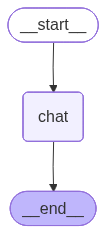

In [84]:
# Using checkpoint
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

# Create graph, add node, add edge and compile

# Create Graph
graph = StateGraph(ChatState)


# Add Node
NODE_CHAT = 'chat'
graph.add_node(NODE_CHAT, chat)

# Add Edge
graph.add_edge(START, NODE_CHAT)
graph.add_edge(NODE_CHAT, END)

workflow = graph.compile(checkpointer=checkpointer)
workflow

In [85]:
thread_id = '1'

while True:
    user_message = input('What is on your mind: ')
    print(f'User: {user_message}')

    if user_message.strip().lower() in ['exit', 'quit', 'bye']:
        break

    config = {'configurable': {'thread_id': thread_id}}

    response = workflow.invoke(
        {
            'messages': [HumanMessage(content=user_message)],
        },
        config=config
    )

    print(f'AI: {response['messages'][-1].content}')

User: My name is pratik
AI: Nice to meet you, Pratik! How can I assist you today?
User: number of chas in my name
AI: The name "Pratik" contains one "a" and one "i," but it does not contain the letter "ch." If you meant something else by "chas," could you please clarify?
User: number of characters
AI: The name "Pratik" has 6 characters. If you have any other questions, feel free to ask!
User: exit


In [86]:
workflow.get_state(config=config)

StateSnapshot(values={'messages': [HumanMessage(content='My name is pratik', additional_kwargs={}, response_metadata={}, id='70e4f5a1-a229-4412-9a5a-3098e730598b'), AIMessage(content='Nice to meet you, Pratik! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 12, 'total_tokens': 27, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-Ca2eCYwjB9D4DnWnfpyGOQBpDDqwW', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--1d251a75-590c-4a0f-bd0b-7f41864bf284-0', usage_metadata={'input_tokens': 12, 'output_tokens': 15, 'total_tokens': 27, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'outpu

#### Persistence


###### Persistence


In [89]:
import os
from pprint import pprint
from dotenv import load_dotenv
from typing import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver

load_dotenv()

model = ChatOpenAI(model='gpt-4o-mini')

In [ ]:
# Node1: Create joke from a topic
# Node2: Explain the joke

class JokeState(TypedDict):
    topic: str
    joke: str
    explanation: str

In [ ]:
def generate_joke(state: JokeState) -> JokeState:
    prompt = f'Generate a joke on the topic: {state['topic']}'
    response = model.invoke(prompt)
    return {'joke': response.content}

In [92]:
def generate_explanation(state: JokeState) -> JokeState:
    prompt = f'Write an explanation for the joke: {state['joke']}'
    response = model.invoke(prompt)
    return {'explanation': response.content}

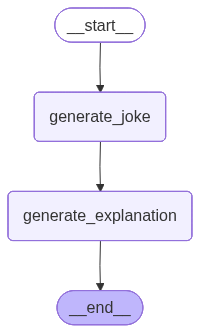

In [95]:
graph = StateGraph(JokeState)

# Add nodes
graph.add_node('generate_joke', generate_joke)
graph.add_node('generate_explanation', generate_explanation)

# Add edges
graph.add_edge(START, 'generate_joke')
graph.add_edge('generate_joke', 'generate_explanation')
graph.add_edge('generate_explanation', END)

# Checkpointer
checkpointer = InMemorySaver()

# Compile
workflow = graph.compile(checkpointer=checkpointer)
workflow

In [96]:
# Chat 1
config1 = {
    'configurable': {'thread_id': '1'}
}

workflow.invoke({'topic': 'pizza'}, config=config1)

{'topic': 'pizza',
 'joke': "Why did the pizza maker go broke?\n\nBecause he just couldn't make enough dough! 🍕😄",
 'explanation': 'The joke plays on a clever double meaning of the word "dough." In the context of a pizza maker, "dough" refers to the mixture of flour and water used to create pizza crust. However, "dough" is also a slang term for money. \n\nSo, when the punchline says the pizza maker "couldn\'t make enough dough," it humorously suggests that he wasn\'t able to produce enough pizza dough for his business while also implying that he wasn\'t earning enough money to stay afloat. This wordplay creates a lighthearted and punny twist to the situation, making it a classic joke.'}

In [97]:
workflow.get_state(config=config1)

StateSnapshot(values={'topic': 'pizza', 'joke': "Why did the pizza maker go broke?\n\nBecause he just couldn't make enough dough! 🍕😄", 'explanation': 'The joke plays on a clever double meaning of the word "dough." In the context of a pizza maker, "dough" refers to the mixture of flour and water used to create pizza crust. However, "dough" is also a slang term for money. \n\nSo, when the punchline says the pizza maker "couldn\'t make enough dough," it humorously suggests that he wasn\'t able to produce enough pizza dough for his business while also implying that he wasn\'t earning enough money to stay afloat. This wordplay creates a lighthearted and punny twist to the situation, making it a classic joke.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bd92d-f948-69c1-8002-832dd20617b4'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-11-09T17:38:16.241388+00:00', parent_config={'configurable': {'thread_id': '1', 

In [141]:
list(workflow.get_state_history(config=config1))

[StateSnapshot(values={'topic': 'paste', 'joke': 'Why did the glue stick break up with the paste?\n\nBecause it found someone more adhesive!', 'explanation': 'This joke is a play on words that involves a pun related to "adhesive," which refers to substances that can bond materials together, like glue and paste. \n\nIn the setup, the glue is anthropomorphized, meaning it\'s treated like a person who can have relationships. The punchline reveals that the glue broke up with the paste because it "found someone more adhesive." This suggests that the glue is in search of a partner that is even better at sticking things together than the paste is. \n\nThe humor comes from the dual meaning: "adhesive" can denote both the literal quality of being able to bond or stick, as well as the notion of finding a "better match" in a romantic context. The whimsy of imagining glue and paste in a romantic scenario adds to the light-heartedness of the joke.'}, next=(), config={'configurable': {'thread_id': '

In [100]:
# Chat 2
config2 = {
    'configurable': {'thread_id': '2'}
}

workflow.invoke({'topic': 'paste'}, config=config2)

{'topic': 'paste',
 'joke': 'Why did the glue stick break up with the paste?\n\nBecause it found someone more adhesive!',
 'explanation': 'This joke is a play on words that involves a pun related to "adhesive," which refers to substances that can bond materials together, like glue and paste. \n\nIn the setup, the glue is anthropomorphized, meaning it\'s treated like a person who can have relationships. The punchline reveals that the glue broke up with the paste because it "found someone more adhesive." This suggests that the glue is in search of a partner that is even better at sticking things together than the paste is. \n\nThe humor comes from the dual meaning: "adhesive" can denote both the literal quality of being able to bond or stick, as well as the notion of finding a "better match" in a romantic context. The whimsy of imagining glue and paste in a romantic scenario adds to the light-heartedness of the joke.'}

In [101]:
workflow.get_state(config=config2)

StateSnapshot(values={'topic': 'paste', 'joke': 'Why did the glue stick break up with the paste?\n\nBecause it found someone more adhesive!', 'explanation': 'This joke is a play on words that involves a pun related to "adhesive," which refers to substances that can bond materials together, like glue and paste. \n\nIn the setup, the glue is anthropomorphized, meaning it\'s treated like a person who can have relationships. The punchline reveals that the glue broke up with the paste because it "found someone more adhesive." This suggests that the glue is in search of a partner that is even better at sticking things together than the paste is. \n\nThe humor comes from the dual meaning: "adhesive" can denote both the literal quality of being able to bond or stick, as well as the notion of finding a "better match" in a romantic context. The whimsy of imagining glue and paste in a romantic scenario adds to the light-heartedness of the joke.'}, next=(), config={'configurable': {'thread_id': '2

In [142]:
list(workflow.get_state_history(config=config2))

[StateSnapshot(values={'topic': 'paste', 'joke': 'Why did the glue stick break up with the paste?\n\nBecause it found someone more adhesive!', 'explanation': 'This joke is a play on words that involves a pun related to "adhesive," which refers to substances that can bond materials together, like glue and paste. \n\nIn the setup, the glue is anthropomorphized, meaning it\'s treated like a person who can have relationships. The punchline reveals that the glue broke up with the paste because it "found someone more adhesive." This suggests that the glue is in search of a partner that is even better at sticking things together than the paste is. \n\nThe humor comes from the dual meaning: "adhesive" can denote both the literal quality of being able to bond or stick, as well as the notion of finding a "better match" in a romantic context. The whimsy of imagining glue and paste in a romantic scenario adds to the light-heartedness of the joke.'}, next=(), config={'configurable': {'thread_id': '

###### Benefits: Fault Tolerance


In [125]:
import time
import os
from typing import TypedDict
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver

In [126]:
# Define the state

class CrashState(TypedDict):
    input: str
    step1: str
    step2: str
    step3: str

In [127]:
# Define steps

def step_1(state: CrashState) -> CrashState:
    print('Step 1 executed')
    return {'step1': 'done', 'input': state['input']}


def step_2(state: CrashState) -> CrashState:
    print('Step 2 hanging... Now manually interrupt the notebook toolbar (STOP button)')
    time.sleep(30)  # Simulate long-running hang
    return {'step2': 'done'}


def step_3(state: CrashState) -> CrashState:
    print('Step 3 executed')
    return {'step3': 'done'}

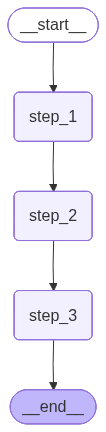

In [128]:
# Build the graph

builder = StateGraph(CrashState)
builder.add_node('step_1', step_1)
builder.add_node('step_2', step_2)
builder.add_node('step_3', step_3)

builder.add_edge(START, 'step_1')
builder.add_edge('step_1', 'step_2')
builder.add_edge('step_2', 'step_3')
builder.add_edge('step_3', END)

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)
graph

In [129]:
try:
    print('Running graph: Please manually interrupt during step 2...')
    graph.invoke(
        {'input': 'start'},
        config={
            'configurable': {'thread_id': '1'}
        }
    )
except KeyboardInterrupt:
    print('Kernel manually interrupted (crash simulated)')

Running graph: Please manually interrupt during step 2...
Step 1 executed
Step 2 hanging... Now manually interrupt the notebook toolbar (STOP button)
Kernel manually interrupted (crash simulated)


In [130]:
# Re run
graph.get_state(config={'configurable': {'thread_id': '1'}})

StateSnapshot(values={'input': 'start', 'step1': 'done'}, next=('step_2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bd96b-43b8-6364-8001-9f4104943669'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-11-09T18:05:41.502846+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bd96b-43b6-67d8-8000-f250b29f8b9c'}}, tasks=(PregelTask(id='d6fe34a3-c1fa-2195-452e-36f695e1ea6e', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [131]:
list(graph.get_state_history(config={'configurable': {'thread_id': '1'}}))

[StateSnapshot(values={'input': 'start', 'step1': 'done'}, next=('step_2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bd96b-43b8-6364-8001-9f4104943669'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-11-09T18:05:41.502846+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bd96b-43b6-67d8-8000-f250b29f8b9c'}}, tasks=(PregelTask(id='d6fe34a3-c1fa-2195-452e-36f695e1ea6e', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'input': 'start'}, next=('step_1',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bd96b-43b6-67d8-8000-f250b29f8b9c'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-11-09T18:05:41.502140+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bd96b-43b4

In [132]:
# Resume from where it was stopped
final_state = graph.invoke(None, config={'configurable': {'thread_id': '1'}})
print(f'Final State: {final_state}')

Step 2 hanging... Now manually interrupt the notebook toolbar (STOP button)
Step 3 executed
Final State: {'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}


In [133]:
graph.get_state(config={'configurable': {'thread_id': '1'}})

StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bd96c-e63b-6fd5-8003-eee41853c5f0'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-11-09T18:06:25.387302+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bd96c-e63a-69fd-8002-67f9ad175f2f'}}, tasks=(), interrupts=())

In [134]:
list(graph.get_state_history(config={'configurable': {'thread_id': '1'}}))

[StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bd96c-e63b-6fd5-8003-eee41853c5f0'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-11-09T18:06:25.387302+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bd96c-e63a-69fd-8002-67f9ad175f2f'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done'}, next=('step_3',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bd96c-e63a-69fd-8002-67f9ad175f2f'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-11-09T18:06:25.386738+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bd96b-43b8-6364-8001-9f4104943669'}}, tasks=(PregelTask(id='6fb79a26-7998-8811-6e1a-80eafecdf8b6', name='s

###### Benefits: Human in the Loop


###### Benefits: Time Travel


In [ ]:
# Go to a particular step in a workflow: for this checkpoint id is needed
workflow.get_state(
    {
        'configurable': {
            'thread_id': '1',
            'checkpoint_id': '1f0bd92d-84cb-6c35-8000-e80b73fed527'
        }
    }
)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f0bd937-7332-65c3-8000-a68910a4a82f'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())

In [ ]:
# Run from middle to the end
workflow.invoke(None,
                {
                    'configurable': {
                        'thread_id': '1',
                        'checkpoint_id': '1f0bd92d-84cb-6c35-8000-e80b73fed527'
                    }
                }
                )

{'topic': 'pizza',
 'joke': 'Why did the pizza apply for a job?\n\nBecause it needed the dough! 🍕',
 'explanation': 'This joke plays on a clever double meaning of the word "dough." In one sense, "dough" refers to the thick mixture used to make pizza crust, which is a literal connection to the pizza itself. In another sense, "dough" is a slang term for money. \n\nSo, when we ask, "Why did the pizza apply for a job?" the punchline, "Because it needed the dough!" suggests that the pizza is seeking employment not just for the sake of making more pizza but also for earning money. The humor comes from the anthropomorphism of the pizza—giving it human-like qualities such as the desire to work and earn money, combined with the pun on "dough."'}

In [140]:
list(workflow.get_state_history(config=config1))

[StateSnapshot(values={'topic': 'paste', 'joke': 'Why did the glue stick break up with the paste?\n\nBecause it found someone more adhesive!', 'explanation': 'This joke is a play on words that involves a pun related to "adhesive," which refers to substances that can bond materials together, like glue and paste. \n\nIn the setup, the glue is anthropomorphized, meaning it\'s treated like a person who can have relationships. The punchline reveals that the glue broke up with the paste because it "found someone more adhesive." This suggests that the glue is in search of a partner that is even better at sticking things together than the paste is. \n\nThe humor comes from the dual meaning: "adhesive" can denote both the literal quality of being able to bond or stick, as well as the notion of finding a "better match" in a romantic context. The whimsy of imagining glue and paste in a romantic scenario adds to the light-heartedness of the joke.'}, next=(), config={'configurable': {'thread_id': '

In [144]:
# Update the state if required, for this also checkpoint_id is required

workflow.update_state({
    'configurable': {
        'thread_id': '1',
        'checkpoint_id': '1f0bd937-7332-65c3-8000-a68910a4a82f',
    }},
    {
        'input': 'samosa'
}
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0bd995-fb18-647f-8000-e8db3ae909c3'}}

In [146]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'paste', 'joke': 'Why did the glue stick break up with the paste?\n\nBecause it found someone more adhesive!', 'explanation': 'This joke is a play on words that involves a pun related to "adhesive," which refers to substances that can bond materials together, like glue and paste. \n\nIn the setup, the glue is anthropomorphized, meaning it\'s treated like a person who can have relationships. The punchline reveals that the glue broke up with the paste because it "found someone more adhesive." This suggests that the glue is in search of a partner that is even better at sticking things together than the paste is. \n\nThe humor comes from the dual meaning: "adhesive" can denote both the literal quality of being able to bond or stick, as well as the notion of finding a "better match" in a romantic context. The whimsy of imagining glue and paste in a romantic scenario adds to the light-heartedness of the joke.'}, next=(), config={'configurable': {'thread_id': '

#### Pass


#### Pass
